# Library Install

In [ ]:
# pip install praw

In [ ]:
# pip install gensim

In [ ]:
# pip install bertopic

# Library Download

This code sets up the environment for text preprocessing and NLP tasks. It first defines Boolean flags (_HAS_SPACY, _HAS_SBERT, _HAS_BERTOPIC, _HAS_GENSIM) to indicate the availability of key libraries for NLP and topic
modeling. It then imports NLTK and Gensim, along with specific modules for stopwords and lemmatization. NLTK datasets—punkt, stopwords, wordnet, omw-1.4, and punkt_tab—are downloaded to enable tokenization, stopword removal, and lemmatization. Finally, a set of English stopwords is created, and a WordNetLemmatizer object is initialized, providing essential tools for cleaning, normalizing, and preparing text data for advanced analysis such as embeddings or topic modeling.

In [ ]:
_HAS_SPACY = True
_HAS_SBERT = True
_HAS_BERTOPIC = True
_HAS_GENSIM = True

import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("punkt_tab", quiet=True)
STOPWORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

# Library Import

This code imports a wide range of libraries and modules required for text processing, NLP, topic modeling, clustering, and machine learning tasks. Core Python modules like os, re, json, and time handle file operations, regular expressions, JSON parsing, and timing operations. Libraries like nltk, spacy, gensim, praw, and SentenceTransformer support tokenization, lemmatization, embeddings, and Reddit data extraction. pandas and numpy manage and analyze data, while seaborn helps in visualization. BERTopic, Word2Vec, LDA, NMF, KMeans, and DBSCAN enable topic modeling and clustering. Scikit-learn modules provide tools for vectorization (TfidfVectorizer, CountVectorizer), model training (LogisticRegression), evaluation (classification_report, accuracy_score), and splitting data (train_test_split). Finally, warnings.filterwarnings("ignore") suppresses unnecessary warning messages during execution, keeping outputs clean and readable.

In [ ]:
import os
import re
import json
import nltk
import time
import praw
import spacy
import gensim
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from bertopic import BERTopic
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# A. Data Collection

In [ ]:
CLIENT_ID = "NxpupKkdJTVW7j-Y0FYhpQ"
CLIENT_SECRET = "NRoWG7ojanGMXmtOur9j77sGaFApYw"
USER_AGENT = "MyResearchProject:v1.0 (by /u/Unusual-Fishing8775)"

This code defines API credentials (CLIENT_ID, CLIENT_SECRET, USER_AGENT) to connect to Reddit via PRAW. The fetch_reddit_praw function takes a list of subreddits and a total post count (size). It splits the number of posts per subreddit, connects to Reddit, and iterates over the hot posts, combining the title and body into full_text. Each post is stored in a dictionary with source, subreddit, text, and timestamp. Finally, all dictionaries are converted into a pandas DataFrame. Errors during fetching are caught and printed, ensuring the loop continues for remaining subreddits.

In [ ]:
def fetch_reddit_praw(subreddits: list[str], size: int = 100):
    if not CLIENT_ID or CLIENT_ID == "YOUR_CLIENT_ID":
        print("!!! Reddit API credentials are not set. Please update CLIENT_ID and CLIENT_SECRET.")
        return pd.DataFrame()

    print("Connecting to Reddit API...")
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT,
    )

    out = []
    limit_per_subreddit = int(size / len(subreddits)) + 1

    print(f"Fetching {limit_per_subreddit} posts from each of these subreddits: {subreddits}")

    for sub in subreddits:
        try:
            subreddit = reddit.subreddit(sub)
            for submission in subreddit.hot(limit=limit_per_subreddit):
                full_text = submission.title + " " + submission.selftext
                out.append({
                    "source": "reddit",
                    "subreddit": sub,
                    "text": full_text.strip(),
                    "created_utc": submission.created_utc
                })
        except Exception as e:
            print(f"Could not fetch data for subreddit '{sub}'. Error: {e}")
            continue

    df = pd.DataFrame(out)
    return df

This function, collect_sample, sets default subreddits if none are provided and calls fetch_reddit_praw to retrieve posts. It prints the subreddits being queried and the target size, then returns the resulting DataFrame, also reporting the total number of posts collected if the DataFrame is not empty.

In [ ]:
def collect_sample(subreddits=None, reddit_size=100):
    if subreddits is None:
        subreddits = ["entrepreneur", "startups", "solopreneurs", "passive_income"]

    print(f"Collecting posts from subreddits: {subreddits} (target total size={reddit_size})")
    df = fetch_reddit_praw(subreddits, size=reddit_size)

    if not df.empty:
        print(f"Collected {len(df)} total items.")
    return df

# B. Pre-processing

The clean_text_basic function preprocesses text by first checking if the input is a string, returning an empty string otherwise. It removes URLs using a regular expression, deletes non-printable or control characters, and finally strips leading and trailing whitespace. This produces cleaner, standardized text suitable for further NLP processing or analysis.

In [ ]:
def clean_text_basic(text: str):
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)
    t = re.sub(r"[\x00-\x1f\x7f-\x9f]", " ", t)
    t = t.strip()
    return t

The normalize_lower_remove_punct function standardizes text by converting it to lowercase, removing all characters except letters, numbers, and whitespace, and replacing multiple spaces with a single space. Finally, it strips leading and trailing spaces. This produces clean, uniform text ideal for NLP tasks like tokenization, vectorization, or topic modeling.

In [ ]:
def normalize_lower_remove_punct(text: str):
    t = text.lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

The tokenize_and_lemmatize function converts text into meaningful tokens while reducing words to their base forms. If use_spacy is True and spaCy is available, it loads the English NLP model, removes spaces, punctuation, URLs, and stopwords, and lemmatizes each token. Otherwise, it uses NLTK to tokenize, lowercase, remove stopwords/non-alphanumeric words, and lemmatize. The function returns a cleaned list of tokens suitable for NLP tasks like embeddings, topic modeling, or clustering.

In [ ]:
def tokenize_and_lemmatize(text: str, use_spacy=False):
    if use_spacy and _HAS_SPACY:
        global _SPACY_NLP
        try:
            _SPACY_NLP
        except NameError:
            try:
                _SPACY_NLP = spacy.load("en_core_web_sm")
            except Exception:
                spacy.cli.download("en_core_web_sm")
                _SPACY_NLP = spacy.load("en_core_web_sm")
        doc = _SPACY_NLP(text)
        tokens = []
        for tok in doc:
            if tok.is_space or tok.is_punct or tok.like_url:
                continue
            if tok.is_stop:
                continue
            lemma = tok.lemma_.strip().lower()
            if lemma and len(lemma) > 1:
                tokens.append(lemma)
        return tokens
    else:
        toks = word_tokenize(text)
        tokens = []
        for w in toks:
            w = w.lower()
            if w in STOPWORDS or not re.match(r"^[a-z0-9]+$", w):
                continue
            lemma = LEMMATIZER.lemmatize(w)
            tokens.append(lemma)
        return tokens

The preprocess_dataframe function cleans and prepares a DataFrame of text data for NLP. It first copies the DataFrame and ensures the text column is a string. It applies clean_text_basic and normalize_lower_remove_punct to standardize text, then tokenizes and lemmatizes using tokenize_and_lemmatize. Rows with empty tokens are removed, tokens are joined into processed_text, and duplicates are dropped. Finally, it returns the DataFrame with raw, cleaned, tokenized, and processed columns, ready for analysis or modeling.

In [ ]:
def preprocess_dataframe(df: pd.DataFrame, use_spacy=False):
    print("Starting preprocessing")
    df = df.copy()
    df["text_raw"] = df["text"].astype(str)

    df["clean_basic"] = df["text_raw"].apply(clean_text_basic)
    df["clean_norm"] = df["clean_basic"].apply(normalize_lower_remove_punct)

    df["tokens"] = df["clean_norm"].apply(lambda t: tokenize_and_lemmatize(t, use_spacy=use_spacy))
    df = df[df["tokens"].apply(len) > 0].reset_index(drop=True)
    df["processed_text"] = df["tokens"].apply(lambda tok: " ".join(tok))

    before = len(df)
    df = df.drop_duplicates(subset=["processed_text"]).reset_index(drop=True)
    after = len(df)
    print(f"Preprocessing done: {before} -> {after} after deduplication")
    return df[["source", "subreddit", "text_raw", "clean_basic", "clean_norm", "tokens", "processed_text", "created_utc"]]

# C. Vectorization

The vectorize_tfidf function converts a list of preprocessed texts into a TF-IDF matrix, capturing the importance of words relative to the corpus. It initializes a TfidfVectorizer with a maximum number of features (max_features) and an n-gram range (ngram). The fit_transform method learns the vocabulary and transforms the texts into a sparse matrix X, which is returned along with the vectorizer for later use.

In [ ]:
def vectorize_tfidf(processed_texts, max_features=2000, ngram=(1, 2)):
    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram)
    X = vec.fit_transform(processed_texts)
    print(f"TF-IDF matrix shape: {X.shape}")
    return X, vec

The vectorize_count function transforms preprocessed texts into a document-term matrix using raw word counts. It creates a CountVectorizer with a specified maximum number of features (max_features) to limit vocabulary size. The fit_transform method learns the vocabulary from the texts and converts them into a sparse matrix X, which, along with the vectorizer, is returned for further analysis or modeling.

In [ ]:
def vectorize_count(processed_texts, max_features=2000):
    vec = CountVectorizer(max_features=max_features)
    X = vec.fit_transform(processed_texts)
    print(f"Count matrix shape: {X.shape}")
    return X, vec

The vectorize_sbert function generates semantic embeddings for a list of preprocessed texts using Sentence-BERT. It first checks if SBERT is available, then loads the specified model (model_name). The encode method transforms texts into dense numerical vectors (emb) representing their semantic meaning. It prints the embedding matrix shape and returns both the embeddings and the model for downstream tasks like clustering or similarity analysis.

In [ ]:
def vectorize_sbert(processed_texts, model_name="all-MiniLM-L6-v2"):
    if not _HAS_SBERT:
        raise RuntimeError("sentence-transformers not installed; install to use SBERT embeddings.")
    model = SentenceTransformer(model_name)
    emb = model.encode(processed_texts, show_progress_bar=True, convert_to_numpy=True)
    print(f"SBERT embeddings shape: {emb.shape}")
    return emb, model

The train_word2vec function trains a Word2Vec model on tokenized text data (token_lists) using Gensim. It checks for Gensim availability, then trains embeddings with specified vector_size, min_count, and epochs. For each document, it averages the vectors of its tokens to create a document-level embedding. If a document has no known tokens, a zero vector is used. The function returns the array of document embeddings and the trained Word2Vec model.

In [ ]:
def train_word2vec(token_lists, vector_size=100, min_count=2):
    if not _HAS_GENSIM:
        raise RuntimeError("gensim not installed; install to use Word2Vec.")
    w2v = Word2Vec(sentences=token_lists, vector_size=vector_size, min_count=min_count, workers=2, epochs=10)
    print("Word2Vec trained")
    doc_vecs = []
    for toks in token_lists:
        vecs = [w2v.wv[w] for w in toks if w in w2v.wv]
        if vecs:
            doc_vecs.append(np.mean(vecs, axis=0))
        else:
            doc_vecs.append(np.zeros(vector_size))
    return np.array(doc_vecs), w2v

# D. Analytics: Topic Modeling & Clustering

### LDA

These two functions perform topic modeling on text data using different algorithms.

run_lda takes a document-term count_matrix and a CountVectorizer. It fits a Latent Dirichlet Allocation (LDA) model with n_topics. For each topic, it identifies the top n_top_words based on component weights and returns both the trained LDA model and a dictionary of topics with their top words.

run_nmf uses a tfidf_matrix and TfidfVectorizer to fit a Non-negative Matrix Factorization (NMF) model. Similarly, it extracts the top words for each topic and returns the NMF model along with a dictionary mapping topics to their top words. Both methods help uncover latent themes in the text corpus.

In [ ]:
def run_lda(count_matrix, count_vectorizer, n_topics=6, n_top_words=10):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(count_matrix)
    terms = count_vectorizer.get_feature_names_out()
    topics = {}
    for i, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[:-n_top_words - 1:-1]
        topics[f"LDA_{i}"] = [terms[idx] for idx in top_idx]
    return lda, topics


def run_nmf(tfidf_matrix, tfidf_vectorizer, n_topics=6, n_top_words=10):
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(tfidf_matrix)
    terms = tfidf_vectorizer.get_feature_names_out()
    topics = {}
    for i, comp in enumerate(nmf.components_):
        top_idx = comp.argsort()[:-n_top_words - 1:-1]
        topics[f"NMF_{i}"] = [terms[idx] for idx in top_idx]
    return nmf, topics

### BERTopic

The run_bertopic_if_available function applies BERTopic topic modeling if the library is installed. It first checks the _HAS_BERTOPIC flag; if not available, it prints a message and returns None. If available, it initializes a BERTopic model, fits it on the processed_texts, and returns the trained model along with the predicted topic labels (topics) and their probabilities (probs) for each document.

In [ ]:
def run_bertopic_if_available(processed_texts):
    if not _HAS_BERTOPIC:
        print("BERTopic not installed — skipping BERTopic.")
        return None
    model = BERTopic(verbose=False)
    topics, probs = model.fit_transform(processed_texts)
    return model, topics, probs

### K-Means

The cluster_kmeans function performs KMeans clustering on a given feature_matrix. It initializes a KMeans model with a specified number of clusters (n_clusters) and a fixed random state for reproducibility. The fit_predict method assigns each data point to a cluster and returns both the cluster labels and the trained KMeans model for further analysis or visualization.

In [ ]:
def cluster_kmeans(feature_matrix, n_clusters=6):
    print("Running KMeans")
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(feature_matrix)
    return labels, km

### Training Classification Models

The train_classifier function trains a Logistic Regression model to predict cluster or topic labels. It first splits the feature matrix (X_features) and labels (y_labels) into training and testing sets (80/20). The model is trained on the training data, then used to predict the test set. It prints the classifier’s accuracy and a detailed classification report, returning the trained model and test results for evaluation.

In [ ]:
def train_classifier(X_features, y_labels):
    print("Training classifier (Logistic Regression) to predict cluster labels")
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print("Classifier accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))
    return clf, (X_test, y_test, preds)

### Trend tracking (simple)

The infer_trends_over_time function analyzes word frequency trends in a processed text DataFrame over time. It checks if the time_col exists; if not, it returns the 20 most common words globally. Otherwise, it converts timestamps to periods (freq, e.g., monthly), groups the data by period, and counts word occurrences in each group. The function returns a dictionary mapping each time period to its top 20 most frequent words, helping identify evolving topics or trends.

In [ ]:
def infer_trends_over_time(df_processed, text_col="processed_text", time_col="created_utc", freq="M"):
    if time_col not in df_processed.columns or df_processed[time_col].isnull().all():
        tokens = " ".join(df_processed[text_col].tolist()).split()
        return {"global": Counter(tokens).most_common(20)}

    df = df_processed.copy()
    df[time_col] = pd.to_datetime(df[time_col], unit="s", errors="coerce")
    df = df.dropna(subset=[time_col])
    df["period"] = df[time_col].dt.to_period(freq)

    period_top = {}
    for period, group in df.groupby("period"):
        toks = " ".join(group[text_col].tolist()).split()
        period_top[str(period)] = Counter(toks).most_common(20)
    return period_top

# Running Simualtion

## A. Data Collection

subreddits=None → If no subreddits are specified, the code will use a predefined list.

reddit_size=120 → Target total number of posts to fetch from all subreddits.

use_spacy=False → Determines whether to use spaCy for tokenization and lemmatization.

vector_method="tfidf" → Text vectorization approach (tfidf, count, sbert, or word2vec).

n_topics=6 → Number of topics for topic modeling algorithms (LDA, NMF, BERTopic).

clustering_method="kmeans" → Clustering algorithm to use on feature vectors.

In [ ]:
subreddits=None
reddit_size=120
use_spacy=False
vector_method="tfidf"
n_topics=6
clustering_method="kmeans"

This code calls collect_sample to fetch Reddit posts using the specified subreddits and reddit_size. It stores the result in df_raw. If no data is returned (i.e., the DataFrame is empty or has zero rows), it prints a message indicating no data was collected and stops further execution, preventing errors in downstream processing.

In [ ]:
df_raw = collect_sample(subreddits=subreddits, reddit_size=reddit_size)
if df_raw.empty or len(df_raw) == 0:
  print("[main] No data collected; exiting")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Connecting to Reddit API...
Fetching 31 posts from each of these subreddits: ['entrepreneur', 'startups', 'solopreneurs', 'passive_income']


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 102 total items.


This code filters the collected Reddit posts for relevance using a keyword-based approach. A list of business-related keywords is defined and joined into a single regular expression pattern. The str.contains method checks each post’s text for these keywords (case-insensitive). Posts matching any keyword are retained in df_filtered, and the number of filtered posts is printed, ensuring only relevant content is analyzed further.

In [ ]:
print(f"\nFiltering {len(df_raw)} collected posts for relevance...")
keywords = [
  'income', 'saas', 'business', 'startup', 'freelance', 'hustle',
  'e-commerce', 'marketing', 'revenue', 'profit', 'customer', 'growth',
  'side hustle', 'mrr', 'arr', 'funding', 'validate'
]
pattern = '|'.join(keywords)
mask = df_raw['text'].str.contains(pattern, case=False, na=False)
df_filtered = df_raw[mask]

print(f"Retained {len(df_filtered)} posts after keyword filtering.")


Filtering 102 collected posts for relevance...
Retained 77 posts after keyword filtering.


This code visualizes the distribution of posts across subreddits. value_counts() counts how many posts come from each subreddit, and reset_index() converts it into a DataFrame with columns subreddit and count. sns.barplot from Seaborn then creates a bar chart, using the “viridis” color palette, showing the number of posts per subreddit for quick visual analysis.

<Axes: xlabel='subreddit', ylabel='count'>

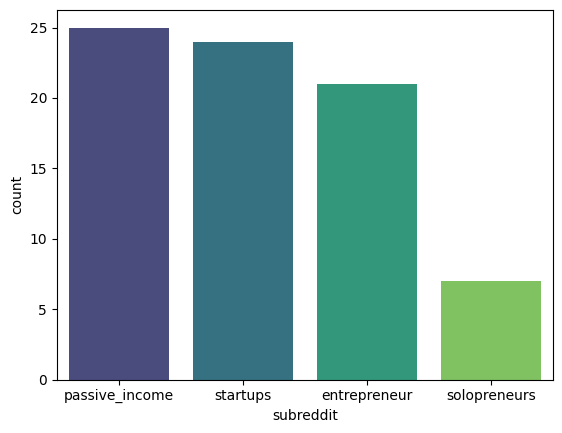

In [ ]:
counts = df_filtered['subreddit'].value_counts().reset_index()
sns.barplot(data=counts, x='subreddit', y='count', palette="viridis")

## B. Pre-processing

This line applies the preprocess_dataframe function to a copy of the filtered DataFrame df_filtered. It cleans the text by applying basic cleaning, normalization, tokenization, and lemmatization (using spaCy if use_spacy=True). The resulting DataFrame df_proc includes additional columns like tokens and processed_text, providing structured, cleaned text ready for vectorization, topic modeling, or clustering.

In [ ]:
df_proc = preprocess_dataframe(df_filtered.copy(), use_spacy=use_spacy)

Starting preprocessing
Preprocessing done: 77 -> 77 after deduplication


## C. Vectorization

This code converts the preprocessed texts into numerical feature representations for modeling, based on the chosen vector_method.

For "tfidf", it creates a TF-IDF matrix (tfidf_X) and a count matrix (count_X), using TF-IDF as the main feature matrix.

For "sbert", it uses SBERT embeddings if available; otherwise, it falls back to TF-IDF.

For "word2vec", it trains a Word2Vec model to generate document embeddings, defaulting to TF-IDF if Gensim is unavailable.

The resulting feature_matrix is used for clustering or classification, while TF-IDF and count matrices are always generated for topic modeling.

In [ ]:
processed_texts = df_proc["processed_text"].tolist()
tokens_lists = df_proc["tokens"].tolist()

if vector_method == "tfidf":
    tfidf_X, tfidf_vec = vectorize_tfidf(processed_texts, max_features=3000)
    count_X, count_vec = vectorize_count(processed_texts, max_features=3000)
    feature_matrix = tfidf_X
elif vector_method == "sbert":
    if not _HAS_SBERT:
        print("SBERT not available, falling back to TF-IDF")
        tfidf_X, tfidf_vec = vectorize_tfidf(processed_texts)
        count_X, count_vec = vectorize_count(processed_texts)
        feature_matrix = tfidf_X
    else:
        emb, sbert_model = vectorize_sbert(processed_texts)
        feature_matrix = emb
        count_X, count_vec = vectorize_count(processed_texts)
        tfidf_X, tfidf_vec = vectorize_tfidf(processed_texts)
elif vector_method == "word2vec":
    if not _HAS_GENSIM:
        print("gensim not available, falling back to TF-IDF")
        tfidf_X, tfidf_vec = vectorize_tfidf(processed_texts)
        count_X, count_vec = vectorize_count(processed_texts)
        feature_matrix = tfidf_X
    else:
        doc_vecs, w2v_model = train_word2vec(tokens_lists)
        feature_matrix = doc_vecs
        count_X, count_vec = vectorize_count(processed_texts)
        tfidf_X, tfidf_vec = vectorize_tfidf(processed_texts)
else:
    raise ValueError("Unknown vector_method")

TF-IDF matrix shape: (77, 3000)
Count matrix shape: (77, 2517)


## D. Analytics: Topic Modeling & Clustering

###  LDA

This code performs LDA topic modeling on the count-based document-term matrix (count_X) using the count_vec for feature names and n_topics topics. The run_lda function returns the trained LDA model (lda_model) and a dictionary of topics (lda_topics). The loop then prints each topic label along with its top words, providing insight into the main themes present in the text corpus.

In [ ]:
lda_model, lda_topics = run_lda(count_X, count_vec, n_topics=n_topics)
print("\nLDA topics (top words):")
for k, v in lda_topics.items():
    print(k, ":", ", ".join(v))


LDA topics (top words):
LDA_0 : like, idea, people, income, business, work, project, guy, month, make
LDA_1 : month, business, make, work, like, time, site, money, want, lead
LDA_2 : business, shirt, would, google, work, online, know, one, like, ad
LDA_3 : business, got, like, would, one, time, 50, promote, feel, even
LDA_4 : product, build, video, saas, month, idea, course, time, user, revenue
LDA_5 : income, product, passive, startup, using, business, market, company, share, get


This code applies NMF topic modeling on the TF-IDF feature matrix (tfidf_X) using the corresponding vectorizer (tfidf_vec) and n_topics topics. The run_nmf function returns the trained NMF model (nmf_model) and a dictionary of topics (nmf_topics). The loop iterates over each topic, printing its label and top words, revealing dominant themes and patterns in the text data.

In [ ]:
nmf_model, nmf_topics = run_nmf(tfidf_X, tfidf_vec, n_topics=n_topics)
print("\nNMF topics (top words):")
for k, v in nmf_topics.items():
    print(k, ":", ", ".join(v))


NMF topics (top words):
NMF_0 : work, want, shirt, money, make, know, something, business, year, month
NMF_1 : start online, online business, start, online, business, money, resource, today, would, creation something
NMF_2 : passive, income, passive income, people, coupon, tiktok, way, automation, free, affiliate
NMF_3 : product, first, video, user, mvp, month, build, saas, problem, course
NMF_4 : startup, investor, roast, maga, please, founder, promote, requirement, ip, idea
NMF_5 : like, feel, feel like, next, would, actually, got, feeling, business, guy


### BERTopic (transformer-based)

This code attempts to run BERTopic if the library is installed (_HAS_BERTOPIC). It calls run_bertopic_if_available on processed_texts, returning the model, topic labels, and probabilities. The results are stored in bert_results. It then prints a sample of the top five topics using get_topic_info(). Any errors during execution are caught and printed, ensuring the script continues without crashing.

In [ ]:
bert_results = None
if _HAS_BERTOPIC:
    try:
        bert_model, bert_topics, bert_probs = run_bertopic_if_available(processed_texts)
        bert_results = {"model": bert_model, "topics": bert_topics, "probs": bert_probs}
        print("BERTopic sample topics info:")
        print(bert_model.get_topic_info().head(5))
    except Exception as e:
        print("BERTopic error:", e)

BERTopic sample topics info:
   Topic  Count                              Name  \
0     -1     24  -1_product_work_business_startup   
1      0     28        0_month_income_like_people   
2      1     25      1_business_feel_like_founder   

                                      Representation  \
0  [product, work, business, startup, saas, video...   
1  [month, income, like, people, business, passiv...   
2  [business, feel, like, founder, promote, start...   

                                 Representative_Docs  
0  [share startup quarterly post share startup q4...  
1  [best passive income idea sept 2025 september ...  
2  [feeling burnt kickstarter sure go b2c b2b pro...  


### Clustering (K-Means & DBSCAN)

This code performs KMeans clustering on the feature_matrix using n_topics as the number of clusters. The cluster_kmeans function returns cluster labels and the trained model. The cluster labels are added to df_proc in a new cluster column. Finally, value_counts() prints the number of posts assigned to each cluster, showing the distribution of documents across clusters.

In [ ]:
labels, cluster_model = cluster_kmeans(feature_matrix, n_clusters=n_topics)
df_proc["cluster"] = labels
print("Cluster sizes:")
print(df_proc["cluster"].value_counts())

Running KMeans
Cluster sizes:
cluster
3    36
5    13
1    10
4     8
0     7
2     3
Name: count, dtype: int64


This line trains a Logistic Regression classifier to predict the KMeans cluster labels using the feature_matrix as input features and the cluster column from df_proc as labels. The train_classifier function splits the data into training and test sets, fits the model, evaluates it with accuracy and a classification report, and returns both the trained classifier (clf) and the test evaluation results (clf_eval).

In [ ]:
clf, clf_eval = train_classifier(feature_matrix, df_proc["cluster"].values)

Training classifier (Logistic Regression) to predict cluster labels
Classifier accuracy: 0.3125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.31      1.00      0.48         5
           5       0.00      0.00      0.00         6

    accuracy                           0.31        16
   macro avg       0.06      0.20      0.10        16
weighted avg       0.10      0.31      0.15        16



### Trend tracking

This code analyzes word frequency trends over time using the infer_trends_over_time function. It groups the processed texts (processed_text) by month (freq="M") based on the created_utc timestamps. The function returns the top words per period. The loop then prints the first three periods with their top eight most frequent words, highlighting evolving topics or trends in the dataset.


In [ ]:
trends = infer_trends_over_time(df_proc, text_col="processed_text", time_col="created_utc", freq="M")
print("\n[Trend] sample (first periods):")
for period, top in list(trends.items())[:3]:
    print(period, "->", top[:8])


[Trend] sample (first periods):
2016-01 -> [('beard', 9), ('started', 7), ('year', 6), ('making', 6), ('actually', 6), ('business', 6), ('also', 5), ('around', 5)]
2018-08 -> [('digital', 2), ('buzzmode', 1), ('distinctive', 1), ('service', 1), ('business', 1), ('enhancement', 1), ('support', 1), ('entity', 1)]
2018-11 -> [('bookkeeping', 2), ('software', 2), ('solopreneurs', 2), ('use', 2), ('pay', 2), ('hi', 1), ('launched', 1), ('easybook', 1)]


In [ ]:
df_proc.head(5)

,source,subreddit,text_raw,clean_basic,clean_norm,tokens,processed_text,created_utc,cluster
0,reddit,entrepreneur,Learned the hard way: not EVERY accountant get...,Learned the hard way: not EVERY accountant get...,learned the hard way not every accountant gets...,"[learned, hard, way, every, accountant, get, e...",learned hard way every accountant get e commer...,1.758187e+09,3
1,reddit,entrepreneur,"Roast my startup Hi, I am the Founder of Podza...","Roast my startup Hi, I am the Founder of Podza...",roast my startup hi i am the founder of podzay...,"[roast, startup, hi, founder, podzay, tool, co...",roast startup hi founder podzay tool connects ...,1.758179e+09,4
2,reddit,entrepreneur,I tested a business idea with just a landing p...,I tested a business idea with just a landing p...,i tested a business idea with just a landing p...,"[tested, business, idea, landing, page, genera...",tested business idea landing page generating 4...,1.758112e+09,3
3,reddit,entrepreneur,How do you guys actually switch off? I’ve been...,How do you guys actually switch off? I’ve been...,how do you guys actually switch off i ve been ...,"[guy, actually, switch, running, little, busin...",guy actually switch running little business ho...,1.758113e+09,3
4,reddit,entrepreneur,Just negotiated scope of work with a $25 milli...,Just negotiated scope of work with a $25 milli...,just negotiated scope of work with a 25 millio...,"[negotiated, scope, work, 25, million, non, pr...",negotiated scope work 25 million non profit ne...,1.758161e+09,2
